# TP 5 : Deep Learning in Practice

**Student :** Théo Di Piazza (theo.dipiazza@gmail.com)

**Master :** MVA - ENS Paris-Saclay

# Koopman decomposition, a toy case: Duffing oscillator


The aim of this notebook is to describe the dynamics of a non-linear dynamical system by means of the Koopman theory.

## Introduction

We consider a quantity $x$ (a vector) which evolves with time, following a dynamical system. Think for example of the joint location of the planets in our solar system, which follows the law of gravitation.

Formally, given an initial state $x(t=0) \in \mathbb{R}^n$ at time $t=0$, the time evolution of $x$ is governed by the following dynamical system:
$$
\dot{x(t)} = f(x(t)) \quad \text(1)
$$

where $\dot{x(t)} := {dx}/{dt}$ is the temporal derivative, and $f:\mathbb{R}^n \rightarrow \mathbb{R}^n$ is a given map describing the dynamics.

For a given $f$, it is not always possible to solve the differential equation (1) analytically. For this reason, instead, numerical schemes are usually employed, to integrate in time $t$ (and space $\Omega$ if needed) the eq (1), so as to propagate the initial condition $x(0)$ up to a desired time $T$; think of $x(T) = x(0) + \int_{t=0}^{T} f(x(t)) dt$. The discretization in time of eq (1) or of the integral introduces numerical approximations, and yields estimates of $x(T)$ of various quality depending on the discretization scheme.

In the field of numerical simulations, discretization schemes have been studied for a long time, and numerical solvers already exist to provide good estimates of integrals (far better than with the naive discretization $x_{t+dt} = x_t + dt\,f(x_t)$, which induces a $O(dt^2)$ error at each time step).

The goal of this practical session is to make use of such numerical solvers to improve the learning of dynamical systems with neural networks.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm

## Duffing oscillator

As a toy example, we consider the Duffing oscillator, where the state $x = (x_1, x_2) \in \mathbb{R}^2$ follows the dynamical system described by the following ODEs:

$$
\dot{x}_1 = x_2\\
\dot{x}_2 = x_1 - x_1^3
$$

To integrate in time the ODEs, a 4th order Runge-Kutta scheme can be used. 


In [2]:
def duffing(t, x : np.ndarray) -> np.ndarray:
    dx = np.zeros(x.shape)
    dx[0] = x[1]
    dx[1] = x[0] -x[0]**3 
    return dx

In [3]:
tmax = 500    #time-horizon integration
niter = 5000  #number of time steps integration
Ninit = 60    #number of initial conditions

X0 = (np.random.rand(Ninit,2)-0.5)*4
t = np.linspace(0, tmax, niter)
Xt = np.zeros((X0.shape[0],X0.shape[1],niter))
for i in tqdm(range(X0.shape[0])):
    f = solve_ivp(duffing, [0,tmax], X0[i], method='RK45',t_eval=t)
    Xt[i,:] = f.y

100%|██████████| 60/60 [00:31<00:00,  1.90it/s]


The following plot shows trajectories for different initial conditions:

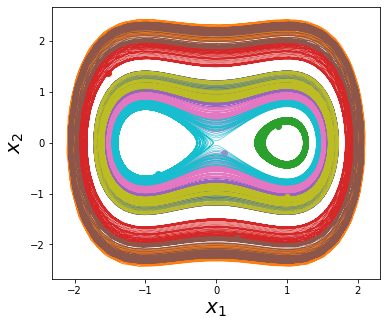

In [4]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(131)
cm = plt.get_cmap("tab10")
print(cm)
for i in range(10):
    ax.plot(Xt[i,0,:], Xt[i,1,:],lw=0.5, color=cm(i))
    ax.plot(Xt[i,0,0], Xt[i,1,0],'o',lw=1.5, color=cm(i)) #initial condition
ax.set_xlabel('$x_1$', fontsize = 20)
ax.set_ylabel('$x_2$', fontsize = 20)
plt.show()

## The Koopman operator
### Discontinuous in time case
Given the discrete non-linear dynamical system

$$
x_{t+1} = \mathbf{F}(x_t)
$$

where $\mathbf{F}$ might be the flow map of the continuous dynamical system in eq (1) and $X = \{x_t | t = 1 \ldots N \}$ the time series of the system state.

$$
\mathbf{F}(x(t_0)) = x(t_0) + \int_{t_0}^{t_0+ t} f(x(\tau))d\tau 
$$

the Koopman theory states that there exists an infinite-dimensional linear operator $\mathcal{K}$ that advances in time all observable functions $g_i: \mathbb{R}^n \rightarrow \mathbb{R}$

$$
\mathcal{K} g_i(x) = g_i \circ \mathbf{F}(x).
$$

This way, the non-linear dynamics of $x$, described by $\mathbf{F}$, can be turned into a **linear** dynamical system, described by $\mathcal{K}$, acting on another representation space, formed by the observable quantities $g_i(x)$.

It is then sufficient to find a function $g: \mathbb{R}^n \rightarrow \mathbb{R}^m$ with $m \gg n$ that embeds the state $x$ into a "larger enough" dimensional space $m$ such that the linear operator $\mathcal{K}$ can be inferred by a matrix $\mathbf{K} \in \mathbb{R}^{m \times m}$.

To project back the dynamics from the Koopman space ($\mathbb{R}^m$, where $g(x)$ lives) to the phase space ($\mathbb{R}^n$, where $x$ lives), a supplementary function $\varphi: \mathbb{R}^m \rightarrow \mathbb{R}^n$ is needed. Going from $x$ to the Koopman space and back yields $\varphi \text{ o  } g = $ Id.

Under this condition, the functions $g$, $\varphi$ and $\mathbf{K}$ can be parametrized $g_{\theta}$, $\varphi_{\rho}$ and $\mathbf{K}_{\phi}$, and the parameters $\theta$, $\rho$ and $\phi$ can be learned minimizing suitable loss functions. 

For this purpose, given a time series $X = \{x_t | t = 1 \ldots N \}$, the following conditions hold:


1.   Reconstruction error
     $$
     \Vert \varphi_\rho (g_\theta(x_t)) - x_t  \Vert = 0
     $$
2.   Prediction error in Koopman space
     $$
     \Vert \mathbf{K_{\phi}} g_{\theta} ( x_t ) - g_{\theta} (x_{t+1})  \Vert = 0
     $$
3.   Prediction error in the phase space
     $$
     \Vert \varphi_{\rho} \left( \mathbf{K_{\phi}} g_{\theta} ( x_t )\right) - x_{t+1} \Vert = 0
     $$

The last three errors can be used as loss functions to train three different neural networks. These different neural networks compose our architecture that can be summarized as in the following sketch:



![architecture](./architecture.png) 

In [39]:
# arrange the dataset
from sklearn.model_selection import train_test_split
X = np.transpose(np.concatenate([Xt[i,:,:-1] for i in range(Xt.shape[0])], axis=1))
Y = np.transpose(np.concatenate([Xt[i,:,1:] for i in range(Xt.shape[0])], axis=1))

X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.2)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(239952, 2) (59988, 2) (239952, 2) (59988, 2)


In [40]:
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.utils.data import DataLoader
torch.set_default_tensor_type('torch.DoubleTensor')

batch_size = 2000     # data per batch

training_data = TensorDataset(torch.from_numpy(X_train),torch.from_numpy(Y_train))
test_data = TensorDataset(torch.from_numpy(X_test),torch.from_numpy(Y_test))

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# create the models
feature_dim = 2       # dimension of the Duffing oscillator
hidden_layer = 5      # number of hidden layers in g (ENCODER) and \varphi (DECODER) 
output_dim = 30       # dimension in Koopman space

In [41]:
class encoder(nn.Module):
    def __init__(self, layer_dim):
        super(encoder, self).__init__()
        self.layer_dim = layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.layer_dim)-1):
            self.list_FC.append(nn.Linear(self.layer_dim[i], self.layer_dim[i+1]))
        
    def forward(self, X):
        for i in range(len(self.layer_dim)-2):
            X = F.elu(self.list_FC[i](X))
        return self.list_FC[-1](X)
        

In [42]:
class decoder(nn.Module):
    def __init__(self, layer_dim):
        super(decoder, self).__init__()
        self.layer_dim = layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.layer_dim)-1,0,-1):
            self.list_FC.append(nn.Linear(self.layer_dim[i], self.layer_dim[i-1]))
        
    def forward(self, X):
        for i in range(len(self.layer_dim)-2):
            X = F.elu(self.list_FC[i](X))
        return self.list_FC[-1](X)

In [43]:
class autoencoder(nn.Module):
    def __init__(self,feature_dim, hidden_layer, output_dim):
        super(autoencoder, self).__init__()
        layer_dim = [output_dim if i == hidden_layer else feature_dim+i*(output_dim-feature_dim)//hidden_layer for i in range(hidden_layer+1)]
        self.encoder = encoder(layer_dim)
        self.decoder = decoder(layer_dim)
    def forward(self, X):
        X = self.encoder(X)
        return self.decoder(X)

The Koopman operator $\mathbf{K}$ (which is linear, and thus a matrix) must have a spectral radius $\rho(\mathbf{K})\le 1$. Such condition will provide a stable -or at least a marginally stable- Koopman operator. To fulfill this requirement, we might leverage on the Perron-Frobenius theorem. 

The Perron-Frobenius th. states: if $\mathbf{K}$ is a $m \times m$ positive matrix i.e. $k_{ij} > 0$ for $1 \le i,j \le m$, then the following inequality holds:

$$
\min_i \sum_j k_{ij} \le \rho(\mathbf{K}) \le \max_i \sum_j k_{ij}
$$


### Question 1

**Question 1.** : Complete the `KoopmanModule` class to enforce $\rho(\mathbf{K})\le 1$, making use of the Perron-Frobenius theorem. Check that the initialization fulfills this property.

**Strategy Question 1. :** As it is said in the TP, "*the Koopman operator $\mathbf{K}$ must have a spectral radius $\rho(\mathbf{K})\le 1$*". This inequality holds if the maximum of the sums of weights over columns of initial weights is below 1. Hence for the implementation, it is needed to check this condition. If it doesn't hold, one can normalize weights by this maximum to force the condition.

In [44]:
class KoopmanModule(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.output_dim = output_dim
        self.weight = torch.randn(output_dim, output_dim)
        ## To Be Implemented
        # check if spectral radius > 1
        max_weight_init = torch.max(self.weight.sum(1, keepdim = True))
        # normalize if needed
        if(max_weight_init > 1):
          self.weight /= max_weight_init
        # weight as parameter
        self.weight = torch.nn.parameter.Parameter(self.weight)

    def forward(self, X):
        x, y = X.shape
        if y != self.output_dim:
            sys.exit(f'Wrong Input Features. Please use tensor with {self.output_dim} Input Features')
        ## To Be Implemented
        # compute the output of Koopman Operator
        output = torch.matmul(X, self.weight.t())

        return output

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [46]:
AUTOENCODER = autoencoder(feature_dim, hidden_layer, output_dim).to(device)
KPM = KoopmanModule(output_dim).to(device)
print(AUTOENCODER)

autoencoder(
  (encoder): encoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=2, out_features=7, bias=True)
      (1): Linear(in_features=7, out_features=13, bias=True)
      (2): Linear(in_features=13, out_features=18, bias=True)
      (3): Linear(in_features=18, out_features=24, bias=True)
      (4): Linear(in_features=24, out_features=30, bias=True)
    )
  )
  (decoder): decoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=30, out_features=24, bias=True)
      (1): Linear(in_features=24, out_features=18, bias=True)
      (2): Linear(in_features=18, out_features=13, bias=True)
      (3): Linear(in_features=13, out_features=7, bias=True)
      (4): Linear(in_features=7, out_features=2, bias=True)
    )
  )
)


In [48]:
opt_aut = torch.optim.Adam(AUTOENCODER.parameters(), lr=0.0001)

opt_kpm = torch.optim.Adam(KPM.parameters(), lr=0.00001)

### Question 2

**Question 2.** : Define a function to compute the loss to be minimized. It should at least include the 3 terms listed above:
- Reconstruction error
- Prediction error in the Koopman space
- Prediction error in the phase space

Because the different objectives outlined by these losses may compete, the training can be difficult. You may try different variations on these losses and comment your findings. In order to improve the training process, one can for instance:
- Add a multiplicative factor in front of each loss component, to balance their importance; how the scales of different losses are related?
- We can refine the loss acting upon the latent space, by using a variational autoencoder approach. This is similar to the Gaussian likelihood used in the first practical (TD1). We want the prediction in the latent space (i.e. the Koopman space) to be a normal distribution $\mathcal{N}(0, 1)$ . Add a corresponding loss for the latent space. Difference to 0 mean and 1 standard deviation must be thus included in the loss;
- Freeze the gradients of one part of the network, for instance the encoder, for one specific objective, using the [`requires_grad`](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html) property. For instance:
```python
criterion = nn.MSELoss()
...
# Compute one part loss_l of the total loss
# First deactivate gradient computation for irrelevant parts of the architecture
for p in AUTOENCODER.encoder.parameters():
    p.requires_grad = False
loss_l = criterion(pred, target)
# Restore the gradient computation
for p in AUTOENCODER.encoder.parameters():
    p.requires_grad = True
...
total_loss = loss_1 + ... + loss_l + ...
return total_loss
```

**Strategy Question 2 :** L'objectif de cette questions est d'implémenter les 3 différentes loss afin de calculer la loss totale :

1.   Reconstruction error
     $$\Vert \varphi_\rho (g_\theta(x_t)) - x_t  \Vert = 0$$
2.   Prediction error in Koopman space
     $$
     \Vert \mathbf{K_{\phi}} g_{\theta} ( x_t ) - g_{\theta} (x_{t+1})  \Vert = 0
     $$
3.   Prediction error in the phase space
     $$
     \Vert \varphi_{\rho} \left( \mathbf{K_{\phi}} g_{\theta} ( x_t )\right) - x_{t+1} \Vert = 0
     $$

As suggested by the subject, it is possible to add regularisation terms $\lambda_1$, $\lambda_2$ and $\lambda_3$ in order to penalise certain losses more. After several experiments, similar coefficients can be taken for these 3 terms.

Finally, I decide to also implement a part to freeze the encoder parameters during the loss calculation.

In [49]:
def LOSS(X_, Y_, X_recon, gX_, gY_, gY_pred, Y_pred):
    '''
    compute the loss to be minimized
    X_ : x_t
    Y_ : x_t+1
    X_recon : reconstruction of X
    gX_ : g(x_t)
    gY_ : g(x_t+1)
    gY_pred : Kg(x_t+1)
    Y_pred : phi(g(x_t+1))
    '''
    # initialize regularization terms
    lambda1, lambda2, lambda3 = 1., 1., 1.
    # MSE Loss
    criterion = nn.MSELoss()

    # First deactivate gradient computation
    for p in AUTOENCODER.encoder.parameters():
      p.requires_grad = False

    # 1. RECONSTRUCTION ERROR
    loss1 = criterion(X_recon, X_)

    # 2. PREDICTION ERROR IN KOOPMAN SPACE
    loss2 = criterion(gY_pred, gY_)

    # 3. PREDICTION ERROR IN THE PHASE SPACE
    loss3 = criterion(Y_pred, Y_)

    # Restore the gradient computation
    for p in AUTOENCODER.encoder.parameters():
      p.requires_grad = True

    # TOTAL LOSS
    total_loss = lambda1*loss1 + lambda2*loss2 + lambda3*loss3
    
    return total_loss, loss1, loss2, loss3

The following cell executes the training loop. You can modify it in order to display the different intermediate losses computed in the function `LOSS` above. How do they evolve in time? Justify your final choice.

In [50]:
for epoch in range(100):
    AUTOENCODER.train() 
    KPM.train()
    total_train_loss = 0
    total_loss1, total_loss2, total_loss3, total_loss4 = 0, 0, 0, 0
    for X_, Y_ in train_dataloader:
        X_, Y_ = X_.to(device), Y_.to(device)
        
        opt_aut.zero_grad()
        opt_kpm.zero_grad()
        
               
        # gX_ = observable(X_), gY_ = observable(Y_)
        gX_ = AUTOENCODER.encoder(X_)
        gY_ = AUTOENCODER.encoder(Y_)
        
        # X_recon = in_observable(observable(X_))
        X_recon = AUTOENCODER.decoder(gX_)
         
        # gY_pred = KPM*observable(X_)
        gY_pred = KPM(gX_)
        
        # Y_pred = inv_observable(KPM*observable(X_))
        Y_pred = AUTOENCODER.decoder(gY_pred)   
            
        output, loss1, loss2, loss3 = LOSS(X_, Y_, X_recon, gX_, gY_, gY_pred, Y_pred)
        total_loss1 += loss1
        total_loss2 += loss2
        total_loss3 += loss3
        output.backward()
        opt_aut.step()
        opt_kpm.step()
    
        if epoch%1 == 0:
            total_train_loss += output.item()/X_.size(0)/len(train_dataloader)
            
    if epoch%1 == 0:        
        print(f'> {epoch} - total_train_loss : {total_train_loss:.6f}')
        print(f'> {epoch} - total reconstruction : {total_loss1:.6f}')
        print(f'> {epoch} - total error in koopman space : {total_loss2:.6f}')
        print(f'> {epoch} - total error in space space : {total_loss3:.6f}')
    
    if epoch%10 == 0:
        AUTOENCODER.eval() 
        KPM.eval()
        with torch.no_grad():
            total_test_loss = 0  
            for X_, Y_ in test_dataloader:
                X_, Y_ = X_.to(device), Y_.to(device)
    
                gX_ = AUTOENCODER.encoder(X_)
                gY_ = AUTOENCODER.encoder(Y_)
                X_recon = AUTOENCODER.decoder(gY_)
                gY_pred = KPM(gX_)
                Y_pred = AUTOENCODER.decoder(gY_pred)   
                    
                output = LOSS(X_, Y_, X_recon, gX_, gY_, gY_pred, Y_pred)
            total_test_loss += output[0].item()/X_.size(0)/len(test_dataloader)
            print('-'*50, 'TEST', '-'*50)
            print(epoch, total_test_loss)
            print('-'*106)
        

> 0 - total_train_loss : 0.001836
> 0 - total reconstruction : 218.410327
> 0 - total error in koopman space : 3.620091
> 0 - total error in space space : 218.614876
-------------------------------------------------- TEST --------------------------------------------------
0 6.169719232426418e-05
----------------------------------------------------------------------------------------------------------
> 1 - total_train_loss : 0.001768
> 1 - total reconstruction : 210.159150
> 1 - total error in koopman space : 1.869235
> 1 - total error in space space : 212.310741
> 2 - total_train_loss : 0.001531
> 2 - total reconstruction : 174.702264
> 2 - total error in koopman space : 4.062070
> 2 - total error in space space : 188.518573
> 3 - total_train_loss : 0.000792
> 3 - total reconstruction : 80.409556
> 3 - total error in koopman space : 12.076842
> 3 - total error in space space : 97.586980
> 4 - total_train_loss : 0.000339
> 4 - total reconstruction : 28.413799
> 4 - total error in koopm

#### Verification

### Question 3

**Question 3.** : We want to ensure the Koopman operator is stable. This can be verified by checking whether its spectral radius $\rho(\mathbf{K})\le 1$. Plot the eigenvalues of the Koopman operator in order to verify the bound on its spectral radius. You can use the [`numpy.linalg.eig`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html) function to retrieve the eigenvalues of a matrix.

<u>**Strategy**</u> In the code below, the objective is to display the eigenvalues of the Koopman operator and check if the condition on the spectral radius is respected or not. If all the points representing the eigenvalues are inside the unit circle then the condition is met, otherwise it is that the condition is not met.

In [51]:
# compute eigen values of Koopman operator
eigenvalues, _ = np.linalg.eig(KPM.weight.detach().cpu().numpy())

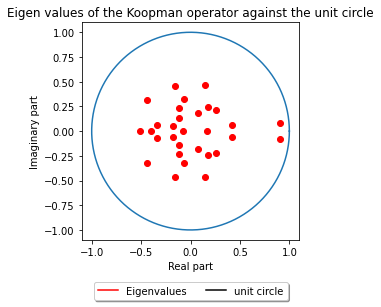

In [52]:
# Step 1 : plot the unit circle
theta = np.linspace(0, 2*np.pi, 1000)
x = np.cos(theta)
y = np.sin(theta)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_aspect('equal')

# Step 2 : plot eigen values
for current_eigen in eigenvalues:
  x, y = current_eigen.real, current_eigen.imag
  plt.scatter(x, y, c='red')

# legend, title
plt.plot(0, 0, c='red', label='Eigenvalues') # will not be displayed
plt.plot(0, 0, c='black', label='unit circle') # will not be displayed
plt.xlabel('Real part'); plt.ylabel('Imaginary part');
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.17), fancybox=True, shadow=True, ncol=5)
plt.title('Eigen values of the Koopman operator against the unit circle')
plt.show()

<u>**Observations**</u> It can be seen that all eigenvalues of the Koopman operator are in the unit circle, which was expected due to the constraint on the spectral radius.

In [53]:
# 'Koop' variable was changed by 'KPM'
N = 30
x = np.linspace(-2, 2, N)
y = np.linspace(-2, 2, N)
xv, yv = np.meshgrid(x, y)

Flow = np.zeros((N,N,2))

for i in range(N):
    for j in range(N):
        Flow[i,j,:] = duffing(0,np.array([xv[i,j],yv[i,j]]))

AUTOENCODER.eval() 
KPM.eval()
Flow_pred = np.zeros((N,N,2))
for i in range(N):
    for j in range(N):
        Flow_pred[i,j,:] = (AUTOENCODER.decoder(
                            torch.matmul(
                            AUTOENCODER.encoder(torch.from_numpy(np.array([[xv[i,j],yv[i,j]]])).to(device)), KPM.weight.t())
                            ).detach().cpu().numpy() - [[xv[i,j],yv[i,j]]]).ravel()/(tmax/niter)
        

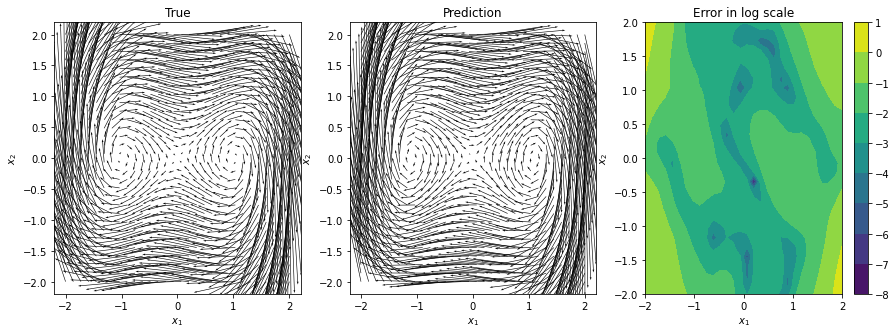

In [54]:
#@title display true, prediction and error
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
ax.quiver(xv,yv, Flow[:,:,0], Flow[:,:,1], scale=10)
ax.set_title('True')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(132)
ax.quiver(xv,yv, Flow_pred[:,:,0], Flow_pred[:,:,1], scale=10)
ax.set_title('Prediction')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(133)
cp = ax.contourf(xv, yv, np.log(np.linalg.norm(Flow - Flow_pred, axis=2)))
fig.colorbar(cp)
ax.set_title('Error in log scale')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

### Continuous in time case

Considering $x_r$ as the observation of a state at time $t$, and $x_{r+1}$ the state at time $t+ \Delta t$, for $\Delta t \rightarrow 0$  it is also possible to define the continuous-time infinitesimal generator of the Koopman operator family as

$$
\mathcal{L} g (x_t)  = \lim_{\Delta t \rightarrow 0} \frac{\mathcal{K}g(x_t)- g(x_{t})}{\Delta t} = \frac{g \circ\mathbf{F} (x_t) -x_t}{\Delta t}
$$

The pevious expression defines the Lie derivative, and for this reason $\mathcal{L}$ is known as the Lie operator. $\mathcal{L}$ describes the continuous dynamics of the observables in the Koopman space:

$$
\dot{g} (x) = \mathcal{L} g(x).
$$

The latter can be further expressed as:

$$
\dot{g} (x(t)) = \frac{dg(x)}{dt} = \nabla_x g \frac{dx}{dt} = \nabla_x g \cdot f(x) =\mathcal{L} g(x).
$$

Given $g_{\theta}$, $\varphi_{\rho}$ and $\mathbf{L}_{\phi}$ three parameterized functions, the following conditions hold:

1.   Reconstruction error
     $$
     \Vert \varphi_\rho (g_\theta(x)) - x  \Vert = 0
     $$
2.   Prediction error in Koopman space
     $$
     \Vert \mathbf{L_{\phi}} g_{\theta} ( x ) - \nabla g_{\theta} \cdot f(x)  \Vert = 0
     $$
3.   Prediction error in the phase space
     $$
     \Vert \varphi_{\rho} \left( \mathbf{L_{\phi}} g_{\theta} ( x )\right) - f(x) \Vert = 0
     $$

As long as the system $f(x)$ is known, the three errors can be computed without data belonging to trajectories. 

In [55]:
# create dataset for continuous Koopman 
# with the same amount of points of the Discontinuous Koopman case
X0 = (np.random.rand(Ninit*(niter-1),2)-0.5)*4 
dX =np.zeros(X0.shape)
for i in tqdm(range(X0.shape[0])):
    dX[i,:] = duffing(0,X0[i,:])

100%|██████████| 299940/299940 [00:00<00:00, 395658.07it/s]


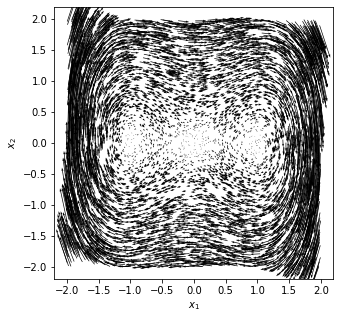

In [56]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.quiver(X0[::50,0],X0[::50,1], dX[::50,0]*0.2, dX[::50,1]*0.2, scale=10)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

In [57]:
# create the models
feature_dim = 2       # dimension of the Duffing oscillator
hidden_layer = 5      # number of hidden layers in g (ENCODER) and \varphi (DECODER) 
output_dim = 30       # dimension in Koopman space
batch_size = 2000     # data per batch

In [58]:
X_train, X_test, Y_train, Y_test =  train_test_split(X0, dX, test_size=0.2)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

training_data = TensorDataset(torch.from_numpy(X_train),torch.from_numpy(Y_train))
test_data = TensorDataset(torch.from_numpy(X_test),torch.from_numpy(Y_test))

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

(239952, 2) (59988, 2) (239952, 2) (59988, 2)


In [59]:
class encoder(nn.Module):
    def __init__(self, layer_dim):
        super(encoder, self).__init__()
        self.layer_dim = layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.layer_dim)-1):
            self.list_FC.append(nn.Linear(self.layer_dim[i], self.layer_dim[i+1]))
        
    def forward(self, X):
        for i in range(len(self.layer_dim)-2):
            X = F.elu(self.list_FC[i](X))
        return self.list_FC[-1](X)

In [60]:
class decoder(nn.Module):
    def __init__(self, layer_dim):
        super(decoder, self).__init__()
        self.layer_dim = layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.layer_dim)-1,0,-1):
            self.list_FC.append(nn.Linear(self.layer_dim[i], self.layer_dim[i-1]))
        
    def forward(self, X):
        for i in range(len(self.layer_dim)-2):
            X = F.elu(self.list_FC[i](X))
        return self.list_FC[-1](X)

In [61]:
class autoencoder(nn.Module):
    def __init__(self,feature_dim, hidden_layer, output_dim):
        super(autoencoder, self).__init__()
        layer_dim = [output_dim if i == hidden_layer else feature_dim+i*(output_dim-feature_dim)//hidden_layer for i in range(hidden_layer+1)]
        self.encoder = encoder(layer_dim)
        self.decoder = decoder(layer_dim)
    def forward(self, X):
        X = self.encoder(X)
        return self.decoder(X)

The Lie operator must be defined such that it will be always stable by construction.
To do that, we consider a matrix of parameters $\Psi \in \mathbb{R}^{m \times m}$ and a vector of parameters $\Gamma \in \mathbb{R}^m$. The resulting Lie operator will be of the form:

$$
\mathbf{L} = (\Psi - \Psi^T) - \text{diag}(\vert \Gamma \vert)
$$

with eigenvalues whose real part $\Re(\lambda) \leq 0$ .
See https://math.stackexchange.com/questions/952233/eigenvalues-of-the-sum-of-a-diagonal-matrix-and-a-skew-symmetric-matrix for the mathematical proof. Moreover if $\lambda \in \mathbb{C}$ is an eigenvalue of $\mathbf{L}$, it turns out that its real part $\Re(\lambda) \propto \Vert \Gamma \Vert$, i.e. it only depends on $\Gamma$. Minimizing the $\Vert \cdot \Vert_{\infty}$ norm, we can force just a few modes to be on the $\Re(\lambda) =0$ axes.



### Question 4

**Question 4.** : As you did for the discrete case, you now have to implement the `LieModule` module. It should have the form indicated above to guarantee $\Re(\lambda) \leq 0$. Check that the initialization fulfills this property.

<u>**Strategy Question 4 :**</u> L'objectif est d'implémenter le module LieModule qui applique le Lie operator à un input donné. Pour cela, il faut tout d'abord définit les paramètres learnable qui sont 

In [62]:
# custom nn.Linear to recover the Lie operator
class LieModule(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.output_dim = output_dim
        self.weight = torch.nn.Parameter(torch.randn(output_dim, output_dim))
        ## To be Implemented
        # implement diagonal matrix : right term of the sum, as a learnable parameter
        self.diagonal = torch.nn.Parameter(torch.diag(torch.abs(torch.randn(output_dim))))

        self.reset_parameters()
        
    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.weight, a=np.sqrt(5))

    def forward(self, X):
        x, y = X.shape
        if x != self.output_dim and y != self.output_dim:
            sys.exit(f'Wrong Input Features. Please use tensor with {self.output_dim} Input Features')
        ## To be Implemented
        # implement L from weight and diagonal matrix
        L = (self.weight - self.weight.t()) - self.diagonal
        # apply L operator to input
        output = torch.matmul(X, L.t())

        # return output and L to match code for Question 5
        return output, L

In [63]:
# start training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [64]:
AUTOENCODER = autoencoder(feature_dim, hidden_layer, output_dim).to(device)
LIE = LieModule(output_dim).to(device)
print(AUTOENCODER)

autoencoder(
  (encoder): encoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=2, out_features=7, bias=True)
      (1): Linear(in_features=7, out_features=13, bias=True)
      (2): Linear(in_features=13, out_features=18, bias=True)
      (3): Linear(in_features=18, out_features=24, bias=True)
      (4): Linear(in_features=24, out_features=30, bias=True)
    )
  )
  (decoder): decoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=30, out_features=24, bias=True)
      (1): Linear(in_features=24, out_features=18, bias=True)
      (2): Linear(in_features=18, out_features=13, bias=True)
      (3): Linear(in_features=13, out_features=7, bias=True)
      (4): Linear(in_features=7, out_features=2, bias=True)
    )
  )
)


Some tricks are needed to train. If the autoencoder and the Lie model are learned at the same speed, the training turns out to be highly unstable since the three loss functions have moving targets. For this reason, the Lie learning rate has been chosen smaller than the autoencoder one.

In [65]:
opt_aut = torch.optim.Adam(AUTOENCODER.parameters(), lr=0.0001, weight_decay=1e-3)
opt_lie = torch.optim.Adam(LIE.parameters(), lr=0.00001, weight_decay=1e-3)

A further loss is considered to stabilize the learning stage. The state $x$ belongs to a compact set, since it is the solution of a dissipative dynamical system. This is not true for $g(x)$ (we need to choose appropriate activation functions to have appropriate Liptchitz guarantees). To avoid discrepancies in magnitudes of $g_i(x)$, a regularization loss is added:

$$
\mu = \frac{1}{m} \sum_m g_i(x) = 0  \quad \text{and} \quad  \sigma = \left( \frac{1}{m}\sum_m(g_i(x)-\mu)^2 \right)^{1/2} = 1
$$

inspired by VAE.

For the training to be smooth, the encoder parameters are not affected by the **prediction loss in phase space**. This is based on an empirical observation and is motivated by the fact that the encoder appears in the three losses and plays a competitive role against the decoder and the Lie model. This should not affect the results since the encoder remains coupled with the decoder in the **reconstruction loss** and with the Lie operator in the **prediction loss in Koopman space**.

### Question 5

**Question 5.** : Implement the loss function similarly to what you did for the **Question 2.**

<u>**Strategy Question 5**</u> In the same way as **Question 2**, we implement the loss by adding the 2 terms in the Loss To avoid discrepancies in magnitudes of $g_i(x)$ : 

$$
\mu = \frac{1}{m} \sum_m g_i(x) = 0  \quad \text{and} \quad  \sigma = \left( \frac{1}{m}\sum_m(g_i(x)-\mu)^2 \right)^{1/2} = 1
$$

In this part, the difference in values between each of the 4 losses is significant, in particular for the loss associated with the reconstruction in LIE space is particularly low. I propose to increase the penalty associated with this loss so that it is more impactful.

In [67]:
def LOSS(X_, dX, gX, dgX, X_recon, dX_recon, jvp):
    # To be Implemented

    # initialize regularization terms
    lambda1, lambda2, lambda3, lambda4 = 1., 90., .75, 1.
    # MSE Loss
    criterion = nn.MSELoss()

    # First deactivate gradient computation
    for p in AUTOENCODER.encoder.parameters():
      p.requires_grad = False

    # 1. RECONSTRUCTION ERROR
    loss1 = criterion(X_recon, X_)

    # 2. PREDICTION ERROR IN LIE SPACE
    loss2 = criterion(dgX, jvp)

    # 3. PREDICTION ERROR IN THE PHASE SPACE
    loss3 = criterion(dX_recon, dX)

    # 4. REGULARIZATION LOSS TO AVOID DISCREPANCIES IN MAGNITUDES 
    #loss4 = torch.mean(gX) + (torch.std(gX) - 1)
    loss4 = torch.mean(gX) + (torch.mean((gX - torch.mean(gX))**2) - 1)

    # Restore the gradient computation
    for p in AUTOENCODER.encoder.parameters():
      p.requires_grad = True

    # TOTAL LOSS
    total_loss = lambda1*loss1 + lambda2*loss2 + lambda3*loss3 + lambda4*loss4

    return total_loss, loss1, loss2, loss3, loss4

Since trajectories are not needed, random states can be sampled from the system manifold $x_1 \in [-2, 2]$, $x_2 \in [-2, 2]$ (see previous figure).

In [68]:
# if True, every loss will be displayed at each epoch
flag_display_all_losses = True

for epoch in range(100):
    AUTOENCODER.train() 
    LIE.train()
    total_train_loss = 0
    total_loss1, total_loss2, total_loss3, total_loss4 = 0, 0, 0, 0
    for X_, dX_ in train_dataloader:
        X_, dX_ = X_.to(device), dX_.to(device)

        opt_aut.zero_grad()
        opt_lie.zero_grad()
         
        # dgX = LIE*gX 
        # jvp = \nabla g * f(X_)
        (gX, jvp) = autograd.functional.jvp(AUTOENCODER.encoder,X_,dX_, create_graph=True)
        X_recon = AUTOENCODER.decoder(gX)
         
        dgX, L = LIE(gX)
        dX_recon = AUTOENCODER.decoder(dgX)
        
        output, loss1, loss2, loss3, loss4 = LOSS(X_, dX_, gX, dgX, X_recon, dX_recon, jvp)
        output.backward()
        opt_aut.step()
        opt_lie.step()
        
        if epoch%1 == 0:
            total_train_loss += output.item()/X_.size(0)/len(train_dataloader)
            total_loss1 += loss1.item()/X_.size(0)/len(train_dataloader)
            total_loss2 += loss2.item()/X_.size(0)/len(train_dataloader)
            total_loss3 += loss3.item()/X_.size(0)/len(train_dataloader)
            total_loss4 += loss4.item()/X_.size(0)/len(train_dataloader)
    if epoch%1 == 0:    
        
        print(f'epoch {epoch} total loss : {total_train_loss}')
        if(flag_display_all_losses):
          print(f'epoch {epoch} loss1 : {total_loss1}')
          print(f'epoch {epoch} loss2 : {total_loss2}')
          print(f'epoch {epoch} loss3 : {total_loss3}')
          print(f'epoch {epoch} loss4 : {total_loss4}')
    
    if epoch%10 == 0:
        AUTOENCODER.eval() 
        LIE.eval()
        with torch.no_grad():
            total_test_loss = 0
            total_loss1, total_loss2, total_loss3, total_loss4 = 0, 0, 0, 0   
            for X_, dX_ in test_dataloader:
                X_, dX_ = X_.to(device), dX_.to(device)
    
                (gX, jvp) = autograd.functional.jvp(AUTOENCODER.encoder,X_,dX_, create_graph=True)
                X_recon = AUTOENCODER.decoder(gX)
         
                dgX, L = LIE(gX)
                dX_recon = AUTOENCODER.decoder(dgX)
            
                output, _, _, _, _ = LOSS(X_, dX_, gX, dgX, X_recon, dX_recon, jvp)
                total_test_loss += output.item()/X_.size(0)/len(test_dataloader)
            print('-'*50, 'TEST', '-'*50)
            print(epoch, total_test_loss)
            print('-'*106)
            

epoch 0 total loss : 0.0024260904812791026
epoch 0 loss1 : 0.0006672977469967515
epoch 0 loss2 : 1.3912706685111523e-05
epoch 0 loss3 : 0.0013531486505537107
epoch 0 loss4 : -0.0005082123552929682
-------------------------------------------------- TEST --------------------------------------------------
0 0.0018536007806797441
----------------------------------------------------------------------------------------------------------
epoch 1 total loss : 0.0015823691212654618
epoch 1 loss1 : 0.0006636829368073426
epoch 1 loss2 : 4.597499266722008e-06
epoch 1 loss3 : 0.0013490222536883
epoch 1 loss4 : -0.0005068554398130863
epoch 2 total loss : 0.0012995153487027678
epoch 2 loss1 : 0.0006577812380058225
epoch 2 loss2 : 1.5682018004281744e-06
epoch 2 loss3 : 0.0013418198926204493
epoch 2 loss4 : -0.000505768970806928
epoch 3 total loss : 0.0011684474855633519
epoch 3 loss1 : 0.0006303079798808358
epoch 3 loss2 : 7.651375574880861e-07
epoch 3 loss3 : 0.0013003241777793022
epoch 3 loss4 : -0.

### Verification

### Question 6

**Question 6.** : As in the **Question 3.** we want to ensure the Lie operator is stable. This can be verified by checking that the real part of the eigenvalues is negative. Plot the relevant eigenvalues of the Lie operator. You can use the [`numpy.linalg.eig`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html) function to retrieve the eigenvalues of a matrix.

<u>**Strategy Question 6**</u> The objective is to verify that the Lie operator is stable. To do so, we have to check that the following condition is met : 

$$\Re(\lambda) \leq 0$$

To do this, we represent the real and imaginary parts of the eigenvalues of the Lie operator, and we check that the real parts are less or equal than 0.

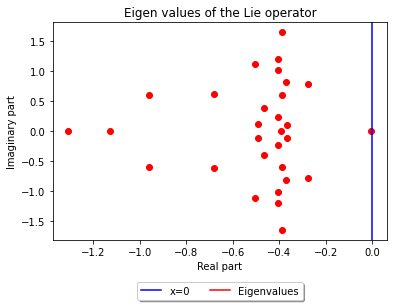

In [69]:
#check LIE stability
# To Be Implemented

# compute eigen values of Koopman operator
eigenvalues, _ = np.linalg.eig(L.detach().cpu().numpy())

# Step 1 : plot eigen values
for current_eigen in eigenvalues:
  x, y = current_eigen.real, current_eigen.imag
  plt.scatter(x, y, c='red')

# Step 2 : plot vertical line st x=0
plt.axvline(x = 0, color = 'b', label = 'x=0')

# legend, title
plt.plot(0, 0, c='red', label='Eigenvalues') # will not be displayed
plt.xlabel('Real part'); plt.ylabel('Imaginary part');
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.17), fancybox=True, shadow=True, ncol=5)
plt.title('Eigen values of the Lie operator')
plt.show()

<u>**Observations**</u> All real parts of the complex numbers are less than 0: the Lie operator is stable.

In [70]:
def DUFFING(x : np.ndarray) -> np.ndarray:
    dx = np.zeros(x.shape)
    dx[0] = x[1]
    dx[1] = x[0] -x[0]**3 
    return dx

N = 30
x = np.linspace(-2, 2, N)
y = np.linspace(-2, 2, N)
xv, yv = np.meshgrid(x, y)

Flow = np.zeros((N,N,2))

for i in range(N):
    for j in range(N):
        Flow[i,j,:] = DUFFING(np.array([xv[i,j],yv[i,j]]))

AUTOENCODER.eval() 
LIE.eval()
Flow_pred = np.zeros((N,N,2))
for i in range(N):
    for j in range(N):
        Flow_pred[i,j,:] =  AUTOENCODER.decoder(
                            torch.matmul(
                            AUTOENCODER.encoder(torch.from_numpy(np.array([[xv[i,j],yv[i,j]]])).to(device)), L.t())
                            ).detach().cpu().numpy()


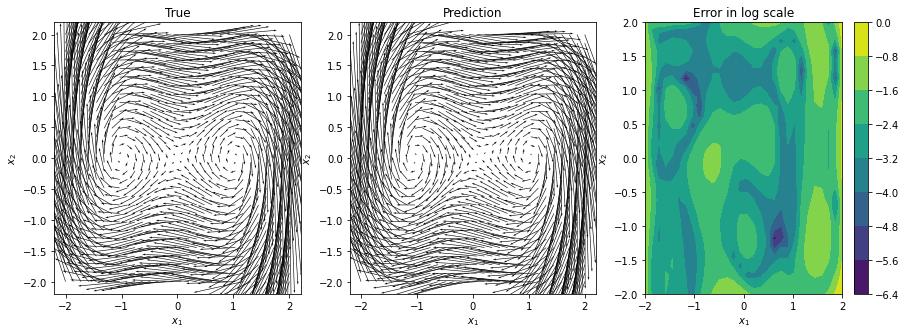

In [71]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
ax.quiver(xv,yv, Flow[:,:,0], Flow[:,:,1], scale=10)
ax.set_title('True')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(132)
ax.quiver(xv,yv, Flow_pred[:,:,0], Flow_pred[:,:,1], scale=10)
ax.set_title('Prediction')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(133)
cp = ax.contourf(xv, yv, np.log(np.linalg.norm(Flow - Flow_pred, axis=2)))
fig.colorbar(cp)
ax.set_title('Error in log scale')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

plt.show()

### Question 7

**Question 7.** : Compare and comment below the two approaches.

<u>**Answer Question 7**</u> In this tutorial, the objective was to implement two methods capable of predicting the dynamics of a non-linear system by means of Koopman's theory. In a first step, we were interested in the discrete case, and in a second step in the continuous case.

**First case :** In the discrete case, 2 components of the model are optimised: the auto-encoder and the Koopman operator. In all, there are 3 losses which are summed with regularisation terms. To ensure the Koopman operator is stable, it is important to verify that the spectral radius $\rho(\mathbf{K})\le 1$. The execution time is 4 minutes with a Tesla K80 GPU available from Google Colab.
 
**Second case :** In the continuous case, 2 components are optimised: the auto-encoder and the Lie operator. Concerning the loss functions, they are the sums of the 3 same terms as the discrete case with the addition of a regularization term to avoid discrepancies in magnitudes of $g_i(x)$. Again, to ensure the stability of the training, we make sure that the real part of the eigenvalues of the Lie Operator are negative. The execution time is 5 minutes with a Tesla K80 GPU available from Google Colab.

**Comparaison :** The comparison is based on the log of the error MSE and the execution times. In both cases, the results seem satisfactory. Indeed, the prediction of the dynamics made by the implemented models are close to the observed reality. It is important to note that the error seems particularly important at the corners of the image. Finally, the continuous method seems to present better results than the discontinuous one, with relatively close execution times.

# End of TP 5 !

Thank you for reading !